In [1]:
# for Google Colab only: Mount my Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
pwd

'/gdrive'

In [3]:
# for Google Colab only: Navigate to my snaug project folder
cd 'My Drive/Colab Notebooks/snaug'

/gdrive/My Drive/Colab Notebooks/snaug


In [4]:
#
# Train models on cloud platforms using GPU, then save only the model weights 
# to be reloaded later on machines without powerful GPU.
#

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import string
import textwrap
import pickle

from nlplstm_class import (TFModelLSTMCharToken, TFModelLSTMWordToken, 
                               TFModelLSTMWord2vec) 
from data_common import (load_doc, save_doc, clean_doc, prepare_char_tokens)
from data_common import (build_token_lines, prepare_text_tokens, load_word2vec)

Using TensorFlow backend.


In [0]:
pathfinder_textfile = './data/textgen_pathfinder.txt'
fixed_length_token_textfile = './data/pathfinder_fixed-length_tokens.txt'

In [6]:
# 
# Loading, saving and pre-processing of the text data source for
# word tokenisation
#
# load document
docs = load_doc(pathfinder_textfile)
#print(docs[:200])
print(textwrap.fill('%s' % (docs[:200]), 80))

The giant black widow spider is a tough, CR 3  poisonous spider. The marsh-
dwelling lizardfolk can be dangerous enemies or helpful—if cautiously
neutral—allies. The flesh-eating minotaur is a tough so


In [7]:
# pre-process and tokenize document
tokens = clean_doc(docs)
print(tokens[:20])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['the', 'giant', 'black', 'widow', 'spider', 'is', 'a', 'tough', 'cr', 'poisonous', 'spider', 'the', 'marsh', 'dwelling', 'lizardfolk', 'can', 'be', 'dangerous', 'enemies', 'or']
Total Tokens: 13097
Unique Tokens: 2925


In [8]:
# organize into fixed-length lines of tokens
lines = build_token_lines(tokens, length=50)
print('Total lines: %d' % len(lines))

Total lines: 13046


In [0]:
# save fixed-length lines to file
save_doc(lines, fixed_length_token_textfile)

In [10]:
# tokenize and separate into features and target
X, y, seq_length, vocab_size, tokenizer = prepare_text_tokens(lines)
print(X.shape)

(13046, 50)


In [11]:
# create new object that is an LSTM model using word tokenization
# and word embedding to generate text
textgen_model_2 = TFModelLSTMWordToken(use_gpu=True)

# define and compile the model parameters
textgen_model_2.define(vocab_size=vocab_size, 
                       embedding_size=100, 
                       seq_length=seq_length)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# LSTM object sanity check
print(textgen_model_2.model_name)
print(textgen_model_2.have_gpu)
print(textgen_model_2.use_cudadnn)
print(textgen_model_2.model.summary())

Word Tokenisation
True
True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           292600    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50, 128)           117760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)           

In [13]:
# compile model
textgen_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = textgen_model_2.fit(X, y, batch_size=128, epochs=200)
#history = textgen_model_2.fit(X, y, batch_size=128, epochs=2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200





13046/13046 [==============================] - 8s 579us/step - loss: 6.9073 - acc: 0.0825
Epoch 2/200
13046/13046 [==============================] - 1s 93us/step - loss: 6.4548 - acc: 0.0838
Epoch 3/200
13046/13046 [==============================] - 1s 94us/step - loss: 6.3010 - acc: 0.0838
Epoch 4/200
13046/13046 [==============================] - 1s 91us/step - loss: 6.1971 - acc: 0.0892
Epoch 5/200
13046/13046 [==============================] - 1s 92us/step - loss: 6.0516 - acc: 0.0980
Epoch 6/200
13046/13046 [==============================] - 1s 91us/step - loss: 5.9360 - acc: 0.1046
Epoch 7/200
13046/13046 [==============================] - 1s 92us/step - loss: 5.8335 - acc: 0.1064
Epoch 8/200
13046/13046 [==============================] - 1s 91us/step - loss: 5.7503 - acc: 0.1068
Epoch 9/200
13046/13046 [==============================] - 1s 92us/step - loss: 5.6760 

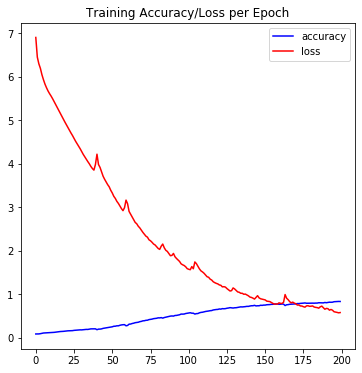

In [14]:
# plot accuracy vs error for training
textgen_model_2.plot_training()

In [0]:
# serialize model weights to HDF5 and save model training history
textgen_model_2.save_weights_and_history(fname_prefix="./model/pathfinder_wordtoken_model_200_epoch")